Simplest simplest, let's start with a linear regression...

In [45]:
import pandas as pd

summary_statistics_df = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/combined_dataset_summary_statistics.csv')
summary_statistics_df = summary_statistics_df.drop(columns=['Unnamed: 0'])
summary_statistics_df

,OD,delta_OD,mean_temperature (C),mean_pH,mean_dO,mean_light_intensity (lumens),std_temperature (C),std_pH,std_dO,std_light_intensity (lumens),...,max_dO,max_light_intensity (lumens),median_temperature (C),median_pH,median_dO,median_light_intensity (lumens),first_last_diff_temperature (C),first_last_diff_pH,first_last_diff_dO,first_last_diff_light_intensity (lumens)
0,0.010775,-0.004198,20.556381,7.241244,0.000000,120.000000,3.073774,0.037676,0.000000,0.000000,...,0.0,120.0,21.10,7.230,0.0,120.0,11.26,-0.139,0.00,0.0
1,0.009115,-0.001660,26.681976,7.193545,0.000000,73.051793,0.869264,0.005209,0.000000,58.570999,...,0.0,120.0,26.85,7.193,0.0,120.0,3.01,0.011,0.00,-120.0
2,0.006383,-0.002731,28.279652,7.213709,0.000000,0.000000,0.191927,0.005496,0.000000,0.000000,...,0.0,0.0,28.32,7.213,0.0,0.0,0.66,0.022,0.00,0.0
3,0.004817,-0.001566,28.631467,7.237450,0.000000,0.000000,0.053756,0.006927,0.000000,0.000000,...,0.0,0.0,28.64,7.238,0.0,0.0,0.16,0.023,0.00,0.0
4,0.003219,-0.001599,28.716657,7.259061,0.000000,0.000000,0.017703,0.006063,0.000000,0.000000,...,0.0,0.0,28.72,7.259,0.0,0.0,0.04,0.016,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.255861,-0.000230,29.055674,7.064157,0.000000,0.000000,0.006418,0.001671,0.000000,0.000000,...,0.0,0.0,29.06,7.064,0.0,0.0,-0.01,0.004,0.00,0.0
188,0.257291,0.001430,28.938962,7.068287,0.000000,4.821714,0.087009,0.002103,0.000000,23.569144,...,0.0,120.0,28.95,7.068,0.0,0.0,-0.27,0.004,0.00,120.0
189,0.255884,-0.001407,28.814240,7.067746,0.000000,120.000000,0.034743,0.002230,0.000000,0.000000,...,0.0,120.0,28.81,7.068,0.0,120.0,0.09,-0.004,0.00,0.0
190,0.256621,0.000738,28.911198,7.063996,0.000000,120.000000,0.031087,0.001569,0.000000,0.000000,...,0.0,120.0,28.92,7.064,0.0,120.0,0.06,-0.005,0.00,0.0


In [46]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
from sklearn.ensemble import RandomForestRegressor

# --- Scikit-learn imports for modeling ---
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configuration ---
CSV_FILE_PATH = None 
HF_COLUMNS = ['temperature (C)', 'pH', 'dO', 'light_intensity (lumens)']

def train_and_evaluate_linear_regression(features_df):
    print("\n--- Training and Evaluating Linear Regression Model with 10-Fold Cross-Validation ---")
    MIN_SAMPLES_FOR_CV = 10 
    if features_df.empty or len(features_df) < MIN_SAMPLES_FOR_CV:
        print(f"Not enough data for 10-fold CV. Need {MIN_SAMPLES_FOR_CV}, found {len(features_df)}.")
        return

    y = features_df['delta_OD']
    X = features_df.drop(columns=['delta_OD', 'OD'])

    if X.empty: print("No features available."); return

    X_filled = X.fillna(X.mean())
    if X_filled.isna().any().any():
        cols_to_drop = X_filled.columns[X_filled.isna().all()].tolist()
        if cols_to_drop:
            X_filled = X_filled.drop(columns=cols_to_drop)
            print(f"Dropped all-NaN columns: {cols_to_drop}")
        if X_filled.empty or X_filled.isna().any().any() :
             print("Features are still problematic after NaN handling."); return
    
    y_aligned = y.loc[X_filled.index]
    if y_aligned.empty:
        print("Target variable y_aligned is empty. Cannot proceed."); return

    pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    mse_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_squared_error', cv=cv)
    mae_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='r2', cv=cv)

    print("\nCross-Validation Model Evaluation Metrics (10-fold):")
    print(f"  Mean Squared Error (MSE): {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(-np.mean(mse_scores)):.4f}")
    print(f"  Mean Absolute Error (MAE): {-np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
    print(f"  R-squared (R²): {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")

    delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

    if not y_aligned.empty:
        min_observed_delta_od = y_aligned.min()
        max_observed_delta_od = y_aligned.max()
        lower_bound = min_observed_delta_od
        upper_bound = max_observed_delta_od

        print(f"\nApplying prediction capping for delta_OD based on observed actual range: [{lower_bound:.4f}, {upper_bound:.4f}]")
        delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, lower_bound, upper_bound)

        num_capped_low = np.sum(delta_od_cv_predictions < lower_bound)
        num_capped_high = np.sum(delta_od_cv_predictions > upper_bound)
        if num_capped_low > 0 or num_capped_high > 0:
            print(f"  Number of original predictions capped at lower bound: {num_capped_low}")
            print(f"  Number of original predictions capped at upper bound: {num_capped_high}")
        else:
            print("  No predictions were outside the observed actual range.")
    else:
        print("Warning: y_aligned is empty, cannot determine capping range. Using original predictions for plots.")
        delta_od_cv_predictions_capped = delta_od_cv_predictions 

    # --- Parity Plot (using CAPPED predictions) ---
    plt.figure(figsize=(9, 9)) # Adjusted size for better legend fit
    
    # Scatter plot of actual vs predicted
    scatter_points = plt.scatter(y_aligned, delta_od_cv_predictions_capped, alpha=0.7, edgecolors='k', s=50) # s for size

    # Draw orthogonal error lines
    for actual_val, pred_val in zip(y_aligned, delta_od_cv_predictions_capped):
        intersect_x = (actual_val + pred_val) / 2
        intersect_y = intersect_x 
        plt.plot([actual_val, intersect_x], [pred_val, intersect_y], color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    min_val = min(y_aligned.min(), delta_od_cv_predictions_capped.min()) - 0.002 # Small buffer
    max_val = max(y_aligned.max(), delta_od_cv_predictions_capped.max()) + 0.002 # Small buffer
    line_of_truth = plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) 
    
    plt.xlabel("Actual delta_OD")
    plt.ylabel("Predicted delta_OD (Cross-Validated & Capped)")
    plt.title("Parity Plot: Actual vs. Capped Predicted delta_OD")
    
    # Custom legend elements
    legend_elements = [
        scatter_points, # Use the returned artist from plt.scatter
        line_of_truth[0], # Use the first (and only) Line2D object from plt.plot
        Line2D([0], [0], color='gray', linestyle='--', lw=0.7, label='Orthogonal Error Lines')
    ]
    # Get labels from the artists themselves if they were set, or define here
    labels = ['Predictions (Capped)', 'Perfect Fit (y=x)', 'Orthogonal Error Lines']
    plt.legend(legend_elements, labels)
    
    plt.xlim(min_val, max_val) # Set limits for a cleaner plot
    plt.ylim(min_val, max_val)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box') # Make it square
    plt.show()

    # --- OD Time Course Plot (using CAPPED predictions) ---
    if not features_df.empty and not y_aligned.empty: 
        initial_actual_od_for_course = features_df['OD'].iloc[0] - features_df['delta_OD'].iloc[0]
        actual_od_course = np.concatenate(([initial_actual_od_for_course], features_df['OD'].loc[y_aligned.index].values))
        
        predicted_od_course = [initial_actual_od_for_course]
        current_predicted_od = initial_actual_od_for_course
        for pred_delta in delta_od_cv_predictions_capped: 
            current_predicted_od += pred_delta
            predicted_od_course.append(current_predicted_od)
        predicted_od_course = np.array(predicted_od_course)

        plot_timestamps = features_df.loc[y_aligned.index].index 
        if len(plot_timestamps) > 1:
            time_diff = plot_timestamps[1] - plot_timestamps[0]
            initial_timestamp = plot_timestamps[0] - time_diff
        elif len(plot_timestamps) == 1 :
             initial_timestamp = plot_timestamps[0] - pd.Timedelta(hours=1) 
        else: 
            initial_timestamp = pd.Timestamp.now() - pd.Timedelta(hours=1)

        full_plot_timestamps = pd.to_datetime([initial_timestamp] + plot_timestamps.tolist())

        plt.figure(figsize=(12, 6))
        plt.plot(full_plot_timestamps, actual_od_course, label='Actual Optical Density', marker='o', linestyle='-')
        plt.plot(full_plot_timestamps, predicted_od_course, label='Predicted Optical Density', marker='x', linestyle='--')
        plt.xlabel("Time")
        plt.ylabel("Optical Density (OD)")
        plt.title("Actual vs. Reconstructed Predicted OD Time Course (Capped Predictions)")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping OD Time Course plot due to insufficient data after alignment.")

    print("\n--- Training Final Model on All Data for Feature Importance ---")
    pipeline.fit(X_filled, y_aligned)
    coefficients_scaled = pipeline.named_steps['regressor'].coef_
    feature_names = X_filled.columns
    coefficients_df = pd.DataFrame(coefficients_scaled, feature_names, columns=['Coefficient'])
    sorted_coefficients = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)
    print("\nFeature Importance (Coefficients from model trained on all data, features were scaled):")
    print(sorted_coefficients)



--- Training and Evaluating Linear Regression Model with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (10-fold):
  Mean Squared Error (MSE): 0.0018 (+/- 0.0055)
  Root Mean Squared Error (RMSE): 0.0428
  Mean Absolute Error (MAE): 0.0044 (+/- 0.0093)
  R-squared (R²): -398.6387 (+/- 1193.8493)

Applying prediction capping for delta_OD based on observed actual range: [-0.0072, 0.0110]
  Number of original predictions capped at lower bound: 0
  Number of original predictions capped at upper bound: 3


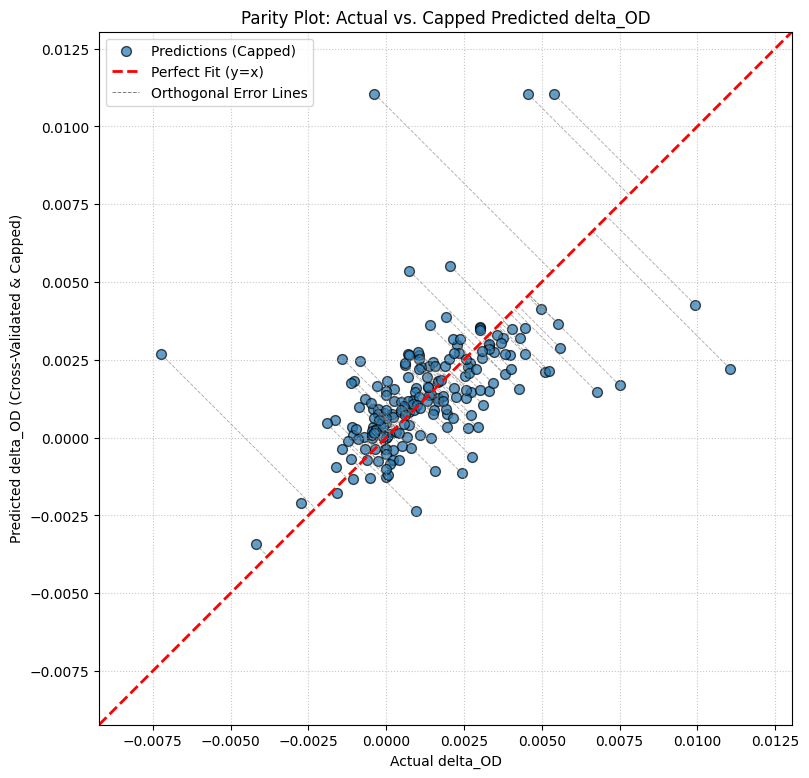

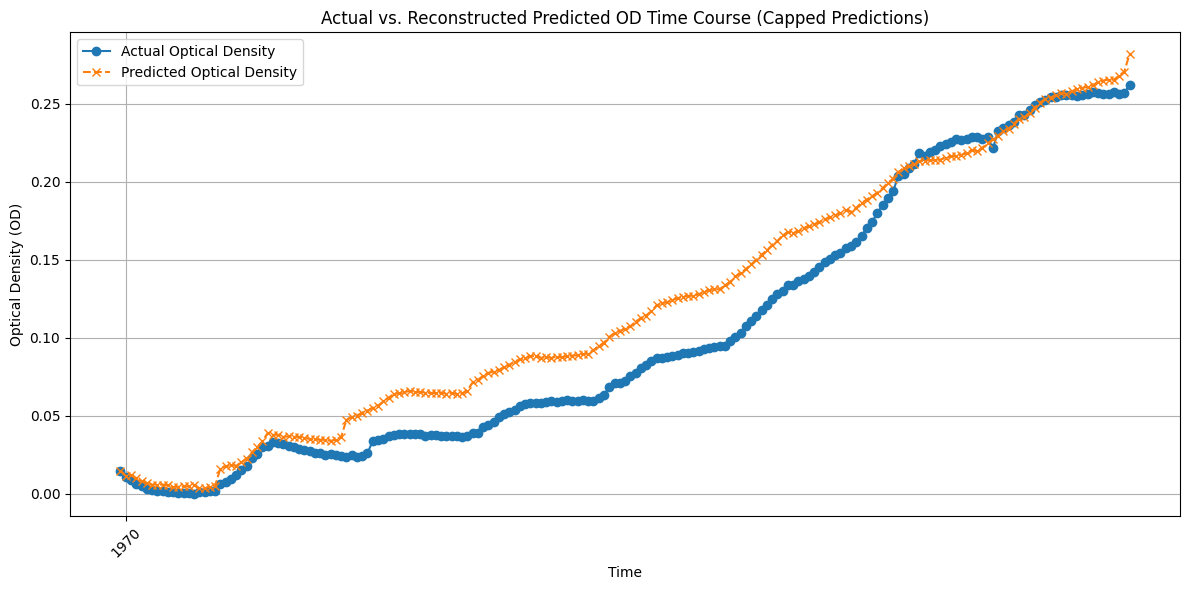


--- Training Final Model on All Data for Feature Importance ---

Feature Importance (Coefficients from model trained on all data, features were scaled):
                                          Coefficient
mean_temperature (C)                         0.037815
min_pH                                      -0.025114
mean_pH                                      0.024223
median_temperature (C)                      -0.018142
min_temperature (C)                         -0.017232
std_dO                                       0.010525
max_dO                                      -0.007748
mean_dO                                     -0.007700
min_dO                                       0.006808
max_temperature (C)                         -0.005141
std_pH                                      -0.004852
first_last_diff_temperature (C)             -0.002966
median_pH                                    0.002077
first_last_diff_pH                          -0.001249
min_light_intensity (lumens)        

In [47]:
train_and_evaluate_linear_regression(summary_statistics_df)

In [48]:
# --- Machine Learning Model Training and Evaluation ---
def train_and_evaluate_random_forest(features_df):
    model_name = "Random Forest Regressor" # Define model name for outputs
    print(f"\n--- Training and Evaluating {model_name} with 10-Fold Cross-Validation ---")
    MIN_SAMPLES_FOR_CV = 10 
    if features_df.empty or len(features_df) < MIN_SAMPLES_FOR_CV:
        print(f"Not enough data for 10-fold CV. Need {MIN_SAMPLES_FOR_CV}, found {len(features_df)}.")
        return

    y = features_df['delta_OD']
    X = features_df.drop(columns=['delta_OD', 'OD'])

    if X.empty: print("No features available."); return

    X_filled = X.fillna(X.mean())
    if X_filled.isna().any().any():
        cols_to_drop = X_filled.columns[X_filled.isna().all()].tolist()
        if cols_to_drop:
            X_filled = X_filled.drop(columns=cols_to_drop)
            print(f"Dropped all-NaN columns: {cols_to_drop}")
        if X_filled.empty or X_filled.isna().any().any() :
             print("Features are still problematic after NaN handling."); return
    
    y_aligned = y.loc[X_filled.index]
    if y_aligned.empty:
        print("Target variable y_aligned is empty. Cannot proceed."); return

    # Define the pipeline with StandardScaler and RandomForestRegressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) # Using RandomForestRegressor
    ])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

    mse_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_squared_error', cv=cv)
    mae_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='neg_mean_absolute_error', cv=cv)
    r2_scores = cross_val_score(pipeline, X_filled, y_aligned, scoring='r2', cv=cv)

    print(f"\nCross-Validation Model Evaluation Metrics ({model_name}, 10-fold):")
    print(f"  Mean Squared Error (MSE): {-np.mean(mse_scores):.4f} (+/- {np.std(mse_scores):.4f})")
    print(f"  Root Mean Squared Error (RMSE): {np.sqrt(-np.mean(mse_scores)):.4f}")
    print(f"  Mean Absolute Error (MAE): {-np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
    print(f"  R-squared (R²): {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")

    delta_od_cv_predictions = cross_val_predict(pipeline, X_filled, y_aligned, cv=cv)

    if not y_aligned.empty:
        min_observed_delta_od = y_aligned.min()
        max_observed_delta_od = y_aligned.max()
        lower_bound = min_observed_delta_od
        upper_bound = max_observed_delta_od

        print(f"\nApplying prediction capping for delta_OD based on observed actual range: [{lower_bound:.4f}, {upper_bound:.4f}]")
        delta_od_cv_predictions_capped = np.clip(delta_od_cv_predictions, lower_bound, upper_bound)

        num_capped_low = np.sum(delta_od_cv_predictions < lower_bound)
        num_capped_high = np.sum(delta_od_cv_predictions > upper_bound)
        if num_capped_low > 0 or num_capped_high > 0:
            print(f"  Number of original predictions capped at lower bound ({lower_bound:.4f}): {num_capped_low}")
            print(f"  Number of original predictions capped at upper bound ({upper_bound:.4f}): {num_capped_high}")
        else:
            print("  No predictions were outside the observed actual range.")
    else:
        print("Warning: y_aligned is empty, cannot determine capping range. Using original predictions for plots.")
        delta_od_cv_predictions_capped = delta_od_cv_predictions 

    # --- Parity Plot (using CAPPED predictions) ---
    plt.figure(figsize=(9, 9)) 
    scatter_points = plt.scatter(y_aligned, delta_od_cv_predictions_capped, alpha=0.7, edgecolors='k', s=50) 
    for actual_val, pred_val in zip(y_aligned, delta_od_cv_predictions_capped):
        intersect_x = (actual_val + pred_val) / 2
        intersect_y = intersect_x 
        plt.plot([actual_val, intersect_x], [pred_val, intersect_y], color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

    min_val_plot = min(y_aligned.min(), delta_od_cv_predictions_capped.min()) - 0.002 
    max_val_plot = max(y_aligned.max(), delta_od_cv_predictions_capped.max()) + 0.002
    line_of_truth = plt.plot([min_val_plot, max_val_plot], [min_val_plot, max_val_plot], 'r--', lw=2) 
    
    plt.xlabel("Actual delta_OD")
    plt.ylabel(f"Predicted delta_OD ({model_name} - CV & Capped)")
    plt.title(f"Parity Plot: Actual vs. Predicted delta_OD ({model_name})")
    
    legend_elements = [
        scatter_points, 
        line_of_truth[0], 
        Line2D([0], [0], color='gray', linestyle='--', lw=0.7, label='Orthogonal Error Lines')
    ]
    labels = ['Predictions (Capped)', 'Perfect Fit (y=x)', 'Orthogonal Error Lines']
    plt.legend(legend_elements, labels)
    
    plt.xlim(min_val_plot, max_val_plot) 
    plt.ylim(min_val_plot, max_val_plot)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_aspect('equal', adjustable='box') 
    plt.show()

    # --- OD Time Course Plot (using CAPPED predictions) ---
    if not features_df.empty and not y_aligned.empty: 
        initial_actual_od_for_course = features_df['OD'].iloc[0] - features_df['delta_OD'].iloc[0]
        actual_od_course = np.concatenate(([initial_actual_od_for_course], features_df['OD'].loc[y_aligned.index].values))
        
        predicted_od_course = [initial_actual_od_for_course]
        current_predicted_od = initial_actual_od_for_course
        for pred_delta in delta_od_cv_predictions_capped: 
            current_predicted_od += pred_delta
            predicted_od_course.append(current_predicted_od)
        predicted_od_course = np.array(predicted_od_course)

        plot_timestamps = features_df.loc[y_aligned.index].index 
        if len(plot_timestamps) > 1:
            time_diff = plot_timestamps[1] - plot_timestamps[0]
            initial_timestamp = plot_timestamps[0] - time_diff
        elif len(plot_timestamps) == 1 :
             initial_timestamp = plot_timestamps[0] - pd.Timedelta(hours=1) 
        else: 
            initial_timestamp = pd.Timestamp.now() - pd.Timedelta(hours=1)

        full_plot_timestamps = pd.to_datetime([initial_timestamp] + plot_timestamps.tolist())

        plt.figure(figsize=(12, 6))
        plt.plot(full_plot_timestamps, actual_od_course, label='Actual OD', marker='o', linestyle='-')
        plt.plot(full_plot_timestamps, predicted_od_course, label=f'Predicted OD ({model_name}, Capped Deltas)', marker='x', linestyle='--')
        plt.xlabel("Time")
        plt.ylabel("Optical Density (OD)")
        plt.title(f"Actual vs. Reconstructed Predicted OD Time Course ({model_name})")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping OD Time Course plot due to insufficient data after alignment.")

    # --- Feature Importance (for Random Forest) ---
    print(f"\n--- Training Final {model_name} on All Data for Feature Importance ---")
    pipeline.fit(X_filled, y_aligned) # Fit the pipeline on all data
    
    # Extract feature importances from the RandomForestRegressor step
    if hasattr(pipeline.named_steps['regressor'], 'feature_importances_'):
        importances = pipeline.named_steps['regressor'].feature_importances_
        feature_names = X_filled.columns
        
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        print(f"\nFeature Importance ({model_name} - Impurity-based):")
        print(sorted_importance_df)
        print("\nNote: Importance values sum to 1 (approximately) and indicate how much each feature contributed to reducing variance (impurity) in the model.")
    else:
        print(f"Feature importances are not available for the regressor: {pipeline.named_steps['regressor']}.")



--- Training and Evaluating Random Forest Regressor with 10-Fold Cross-Validation ---

Cross-Validation Model Evaluation Metrics (Random Forest Regressor, 10-fold):
  Mean Squared Error (MSE): 0.0000 (+/- 0.0000)
  Root Mean Squared Error (RMSE): 0.0017
  Mean Absolute Error (MAE): 0.0011 (+/- 0.0003)
  R-squared (R²): 0.2930 (+/- 0.2572)

Applying prediction capping for delta_OD based on observed actual range: [-0.0072, 0.0110]
  No predictions were outside the observed actual range.


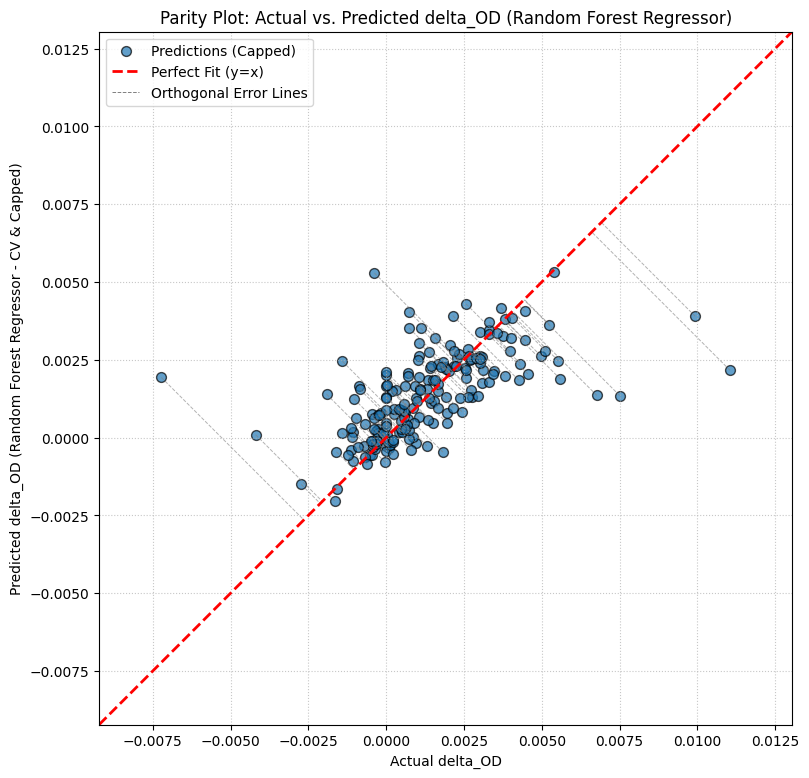

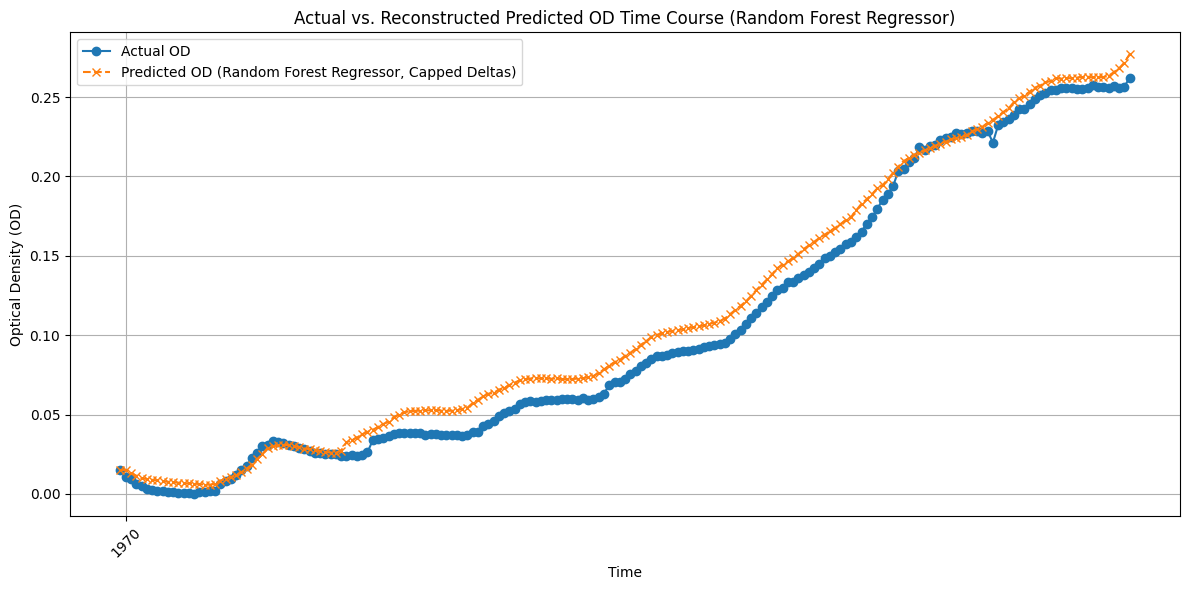


--- Training Final Random Forest Regressor on All Data for Feature Importance ---

Feature Importance (Random Forest Regressor - Impurity-based):
                                     Feature  Importance
9                                     min_pH    0.103834
4                        std_temperature (C)    0.078946
3              mean_light_intensity (lumens)    0.067317
1                                    mean_pH    0.065258
22                        first_last_diff_dO    0.064358
12                       max_temperature (C)    0.060656
10                                    min_dO    0.054054
5                                     std_pH    0.052637
13                                    max_pH    0.051888
11              min_light_intensity (lumens)    0.049202
8                        min_temperature (C)    0.046546
0                       mean_temperature (C)    0.041702
14                                    max_dO    0.037293
6                                     std_dO    0.03588

In [49]:
train_and_evaluate_random_forest(summary_statistics_df)

# Shall we throw a 1D-CNN at it?